# CRE/MF Mortgage Rate Model Off-ValidMind

# Setup

In [1]:
# Data libraries 
import pandas as pd
import missingno as msno
from tabulate import tabulate

# ML libraries
import statistics
import random
import numpy as np
from numpy import argmax
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from arch.unitroot import ZivotAndrews
from arch.unitroot import DFGLS
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
%matplotlib inline

# Load Data 

In [2]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)

# Remove diff columns
columns_to_remove = [col for col in df.columns if col.startswith("diff")]
df = df.drop(columns=columns_to_remove)
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,FEDFUNDS
Date,,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000,5.02
2007-09-01,7.841429,9.276667,10.829167,12.436667,4.94
2007-10-01,7.830000,9.433333,10.825926,12.737368,4.76
2007-11-01,7.779091,9.467778,10.967037,12.609444,4.49
2007-12-01,7.695833,9.387500,10.805000,12.478889,4.24


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2007-08-01 to 2018-12-01
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_rate_A  137 non-null    float64
 1   loan_rate_B  137 non-null    float64
 2   loan_rate_C  137 non-null    float64
 3   loan_rate_D  137 non-null    float64
 4   FEDFUNDS     137 non-null    float64
dtypes: float64(5)
memory usage: 6.4 KB


### Visual Inspection

Time Series Plots.

In [4]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_time_series(df, subplot=False):
    """
    Plots the columns of a DataFrame as line charts or subplots.

    Args:
        df (pd.DataFrame): The DataFrame to plot.
        subplot (bool): Whether to plot each variable as a separate subplot or as a combined line chart.

    Returns:
        None
    """
    # Get the list of column names
    columns_to_plot = list(df.columns)

    if subplot:
        # Initialize the figure with subplots
        fig = make_subplots(rows=len(columns_to_plot), cols=1, shared_xaxes=True, vertical_spacing=0.05)

        # Add a subplot trace for each series
        for i, column in enumerate(columns_to_plot):
            fig.add_trace(go.Scatter(x=df.index, y=df[column], name=column, mode='lines'), row=i+1, col=1)

        # Customize the layout
        fig.update_layout(title='Loan Rates and Federal Funds Rate', height=800)

    else:
        # Initialize the figure
        fig = go.Figure()

        # Add a line trace for each series
        for column in columns_to_plot:
            fig.add_trace(go.Scatter(x=df.index, y=df[column], name=column, mode='lines'))

        # Customize the layout
        fig.update_layout(title='Loan Rates and Federal Funds Rate',
                          xaxis_title='Date',
                          yaxis_title='Interest Rates')

    return fig


fig = plot_time_series(df)
fig.show()

# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

 ## A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

In [5]:
missing_values = df.isnull().sum() / len(df) * 100
missing_values_df = pd.DataFrame({"column_name": missing_values.index, "missing_percentage": missing_values.values})
missing_values_df = missing_values_df.sort_values("missing_percentage", ascending=False)

**Step 2: Display the missing values percentage in a table format**

In [6]:
display(missing_values_df)

,column_name,missing_percentage
0,loan_rate_A,0.0
1,loan_rate_B,0.0
2,loan_rate_C,0.0
3,loan_rate_D,0.0
4,FEDFUNDS,0.0


**Step 3: Visualize the missing values**

Create a bar plot to show the missing values percentage per column.

In [7]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=missing_values_df["missing_percentage"],
    y=missing_values_df["column_name"],
    orientation="h"
))

fig.update_layout(
    title="Percentage of Missing Values per Column",
    xaxis_title="Percentage",
    yaxis_title="Column Name"
)

fig.show()


Create a matrix plot to show the pattern of missing values in the dataset.

In [8]:
# Create a boolean dataframe indicating missing values (True if missing)
missing_values_bool = df.isnull()

# Replace True with 1 and False with 0
missing_values_matrix = missing_values_bool.replace({True: 1, False: 0})

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=missing_values_matrix.T,  # Transpose the matrix to match the orientation
    x=missing_values_matrix.columns,
    y=missing_values_matrix.index,
    colorscale=[[0, 'white'], [1, 'red']],
    showscale=False
))

fig.update_layout(
    title="Missing Values Matrix",
    xaxis_title="Columns",
    yaxis_title="Index",
    xaxis=dict(tickangle=45),  # Rotate column labels for better readability
)

fig.show()


**Step 4: Analyze the patterns of missing values**

Based on the bar plot and matrix plot, analyze if the missing values are random or if there are specific patterns in the data.

**Step 5: Handle missing values**

Based on the analysis, decide how to handle the missing values. 

 ## B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

In [9]:
fig = go.Figure()

# Add box plots for each column in the dataset
for col in df.columns:
    fig.add_trace(go.Box(y=df[col], name=col))

fig.update_layout(
    title="Box Plots for All Columns in the Dataset",
    xaxis_title="Columns",
    yaxis_title="Values"
)

fig.show()

**Step 2: Identify outliers using Z-scores**

- Calculate the Z-scores for each column in your dataset to identify data points that are far from the mean.
- Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

In [10]:
import pandas as pd
import numpy as np

def identify_outliers(df, threshold):
    """
    Identifies outliers in a DataFrame using the Z-score method.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (float): The Z-score threshold for identifying outliers.

    Returns:
        outliers_df (pd.DataFrame): A DataFrame containing the row and column indices of the outliers.
    """
    outliers = []
    for col in df.columns:
        # Calculate the Z-scores for the column
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())

        # Identify the outliers in the column
        col_outliers = np.where(z_scores > threshold)[0]

        # Append the column and row indices to the outliers list
        outliers.extend([(row_idx, col) for row_idx in col_outliers])

    # Create the outliers DataFrame
    outliers_df = pd.DataFrame(outliers, columns=['row', 'column'])

    return outliers_df



In [11]:
outliers_df = identify_outliers(df, threshold=3)

**Step 3: Analyze the outliers**

Number of outliers per variable.

In [12]:
def plot_outliers_count(df, outliers_df):
    """
    Plots the count of outliers for each variable in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to plot.
        outliers_df (pd.DataFrame): A DataFrame containing the row and column indices of the outliers.

    Returns:
        fig (plotly.graph_objects.Figure): A Plotly figure object.
    """
    # Initialize an empty list to store the count of outliers for each column
    outliers_count_list = []

    # Iterate over the dataset columns
    for column_name in df.columns:
        # Filter the 'outliers_df' for the current column
        column_outliers_df = outliers_df[outliers_df["column"] == column_name]

        # Count the outliers for the current column and add to the list
        outliers_count_list.append(len(column_outliers_df))

    # Create a bar plot using Plotly for the entire dataset
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=df.columns,
        y=outliers_count_list,
        hovertemplate="Column: %{x}<br>Outliers Count: %{y}<extra></extra>",
    ))

    fig.update_layout(
        title="Outliers Count for Each Variable",
        xaxis_title="Variable",
        yaxis_title="Outliers Count",
    )
    
    return fig

In [13]:
fig = plot_outliers_count(df, outliers_df)
fig.show()

Time sers plots with outliers marked.

In [14]:
def plot_outliers(df, outliers_df):
    """
    Plots the outliers for each variable in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to plot.
        outliers_df (pd.DataFrame): A DataFrame containing the row and column indices of the outliers.

    Returns:
        List[go.Figure]: A list of Plotly figure objects containing the scatter plots.
    """
    # Create an empty list to store the figures
    figures = []

    # Iterate over the dataset columns
    for column_name in df.columns:
        # Filter the 'outliers_df' for the current column
        column_outliers_df = outliers_df[outliers_df["column"] == column_name]

        # Get the indices of the outliers and non-outliers
        outlier_indices = column_outliers_df["row"].tolist()
        non_outlier_indices = [j for j in range(len(df)) if j not in outlier_indices]

        # Get the non-outlier and outlier data
        non_outlier_data = df.iloc[non_outlier_indices][column_name]
        outlier_data = df.iloc[outlier_indices][column_name]

        # Create a scatter plot using Plotly for the current column
        fig = go.Figure()

        # Add non-outlier data
        fig.add_trace(go.Scatter(
            x=non_outlier_data.index,
            y=non_outlier_data,
            mode="markers",
            name="Non-Outliers",
            marker=dict(color='blue', size=6),
            hovertemplate="Date: %{x}<br>Value: %{y}<extra></extra>",
        ))

        # Add outlier data
        fig.add_trace(go.Scatter(
            x=outlier_data.index,
            y=outlier_data,
            mode="markers",
            name="Outliers",
            marker=dict(color='red', size=8, symbol='star'),
            hovertemplate="Date: %{x}<br>Value: %{y}<extra></extra>",
        ))

        fig.update_layout(
            title=f"Scatter Plot with Outliers for {column_name}",
            xaxis_title="Date",
            yaxis_title=column_name,
        )

        # Append the figure to the list
        figures.append(fig)

    return figures

In [15]:
figures = plot_outliers(df, outliers_df)
for fig in figures:
    fig.show()


**Step 5: Handle the outliers**

## C. Stationarity Analysis

The first step in any time series analysis is to visualize the data and check for stationarity. Stationarity is important because most time series models, including ARIMA, assume that the underlying data is stationary.

**Unit Root Tests**

In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS

def unit_root_tests(dataset, p_value_threshold=0.05):
    """
    Calculate p-values for ADF, KPSS, Phillips-Perron, Zivot-Andrews, and DFGLS tests for each variable,
    and determine if their time series is stationary or not based on the p-value threshold.

    Args:
        dataset (pd.DataFrame): A DataFrame containing the time series data.
        p_value_threshold (float): The p-value threshold for determining stationarity (default: 0.05).

    Returns:
        pd.DataFrame: A DataFrame containing the series, test names, p-values, threshold, pass/fail results, and stationarity decision.
    """
    results = []

    for column_name in dataset.columns:
        series = dataset[column_name]

        test_names = ['ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS']
        p_values = [
            adfuller(series)[1],
            kpss(series, nlags="auto")[1],
            PhillipsPerron(series).pvalue,
            ZivotAndrews(series).pvalue,
            DFGLS(series).pvalue
        ]

        for test_name, p_value in zip(test_names, p_values):
            if test_name == 'KPSS':
                pass_fail = 'Pass' if p_value < p_value_threshold else 'Fail'
                decision = 'stationary' if pass_fail == 'Pass' else 'non-stationary'
            else:
                pass_fail = 'Pass' if p_value > p_value_threshold else 'Fail'
                decision = 'non-stationary' if pass_fail == 'Pass' else 'stationary'

            results.append({
                'Series': column_name,
                'Test': test_name,
                'p-value': p_value,
                'Threshold': p_value_threshold,
                'Pass/Fail': pass_fail,
                'Decision': decision
            })

    test_results = pd.DataFrame(results)
    return test_results

test_results = unit_root_tests(df)
display(test_results)



/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtual

,Series,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,ADF,0.323972,0.05,Pass,non-stationary
1,loan_rate_A,KPSS,0.010000,0.05,Pass,stationary
2,loan_rate_A,Phillips-Perron,0.274663,0.05,Pass,non-stationary
3,loan_rate_A,Zivot-Andrews,0.680477,0.05,Pass,non-stationary
4,loan_rate_A,DFGLS,0.071277,0.05,Pass,non-stationary
5,loan_rate_B,ADF,0.022424,0.05,Fail,stationary
6,loan_rate_B,KPSS,0.100000,0.05,Fail,non-stationary
7,loan_rate_B,Phillips-Perron,0.129150,0.05,Pass,non-stationary
8,loan_rate_B,Zivot-Andrews,0.011857,0.05,Fail,stationary
9,loan_rate_B,DFGLS,0.166778,0.05,Pass,non-stationary


Interpretation of Unit Root Tests. 

*The results for the `loan_rate_A` series show mixed evidence for stationarity. The ADF, Phillips-Perron, Zivot-Andrews, and DFGLS tests suggest that the series is **non-stationary**, while the KPSS test indicates that the series is stationary.* 

*The results for the `loan_rate_B` series also show mixed evidence for stationarity. The ADF and Zivot-Andrews tests suggest that the series is stationary, while the KPSS, Phillips-Perron, and DFGLS tests indicate that the series is **non-stationary**.* 

*Given that the majority of the tests suggest non-stationarity, it is more likely that the `loan_rate_C` series is **non-stationary**.*

*Given that the majority of the tests suggest non-stationarity, it is more likely that the `loan_rate_D` series is **non-stationary**.*

*The results for the `FEDFUNDS` series suggest that the series is **non-stationary**. The ADF test indicates that the series is non-stationary, while the KPSS test also suggests non-stationarity, failing to meet the p-value threshold. Similarly, the Phillips-Perron test also indicates non-stationarity. However, the Zivot-Andrews and DFGLS tests both suggest stationarity, which may be an indication that the series contains **structural breaks**.*


**Making Series Stationary**

Compute first difference. 

In [17]:
diff_df = df.diff().dropna()

Inspect time series.

In [18]:
fig = plot_time_series(diff_df, subplot=True)
fig.show()

Run Unit Root Tests. 

In [19]:
test_results = unit_root_tests(diff_df)
display(test_results)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/Users/juanvalidmind/Library/Caches/pypoetry/virtual

,Series,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,ADF,3.628392e-18,0.05,Fail,stationary
1,loan_rate_A,KPSS,1.000000e-01,0.05,Fail,non-stationary
2,loan_rate_A,Phillips-Perron,3.175252e-18,0.05,Fail,stationary
3,loan_rate_A,Zivot-Andrews,1.000000e-05,0.05,Fail,stationary
4,loan_rate_A,DFGLS,8.038705e-16,0.05,Fail,stationary
5,loan_rate_B,ADF,7.693931e-14,0.05,Fail,stationary
6,loan_rate_B,KPSS,1.000000e-01,0.05,Fail,non-stationary
7,loan_rate_B,Phillips-Perron,4.947175e-14,0.05,Fail,stationary
8,loan_rate_B,Zivot-Andrews,1.000000e-05,0.05,Fail,stationary
9,loan_rate_B,DFGLS,6.978825e-09,0.05,Fail,stationary


Interpret Unit Root Tests.

*All series are assumed to be **stationary after differencing once**.* 

In [20]:
df = diff_df.copy()

## C. Seasonality Analysis

**Step 1: Seasonal decomposition**

Compute seasonal decomposition on each time series.

In [21]:

def compute_seasonal_decomposition(data, model='additive'):
    """
    Compute seasonal decomposition for a given time series.

    Args:
        data (pd.Series): The time series data.
        model (str): The decomposition model, either 'additive' or 'multiplicative'.

    Returns:
        decomposition (DecomposeResult): The seasonal decomposition result.
    """
    decomposition = seasonal_decompose(data, model=model)
    return decomposition

In [22]:
# Initialize an empty dictionary to store the decomposition results
decomposition_dict = {}

# Iterate over the dataset columns
for column_name in df.columns:
    # Compute seasonal decomposition
    decomposition = compute_seasonal_decomposition(df[column_name])

    # Store the decomposition result in the dictionary
    decomposition_dict[column_name] = decomposition

**Step 2: Visualize seasonal decomposition**

Create plots for seasonal components.

In [23]:
def plot_seasonal_decomposition(decomposition_dict, column_name):
    """
    Plot seasonal decomposition components.

    Args:
        decomposition_dict (dict): A dictionary containing seasonal decomposition results
                                   for each variable in the dataset.
        column_name (str): The name of the time series variable to plot.
    """
    decomposition = decomposition_dict[column_name]

    fig = make_subplots(rows=1, cols=4, shared_xaxes=True,
                        subplot_titles=('Original Data', 'Trend', 'Seasonal', 'Residual'))

    # Add original data trace
    fig.add_trace(go.Scatter(x=decomposition.observed.index,
                             y=decomposition.observed.values,
                             mode='lines',
                             name='Original Data'), row=1, col=1)

    # Add trend trace
    fig.add_trace(go.Scatter(x=decomposition.trend.index,
                             y=decomposition.trend.values,
                             mode='lines',
                             name='Trend'), row=1, col=2)

    # Add seasonal trace
    fig.add_trace(go.Scatter(x=decomposition.seasonal.index,
                             y=decomposition.seasonal.values,
                             mode='lines',
                             name='Seasonal'), row=1, col=3)

    # Add residual trace
    fig.add_trace(go.Scatter(x=decomposition.resid.index,
                             y=decomposition.resid.values,
                             mode='lines',
                             name='Residual'), row=1, col=4)

    # Set plot layout
    fig.update_layout(title=f"Seasonal Decomposition for {column_name}",
                      height=300)

    # Set the y-axis range of the remaining subplots to the range of the observed data
    fig.update_yaxes(range=[decomposition.observed.min(), decomposition.observed.max()], row=1, col=2)
    fig.update_yaxes(range=[decomposition.observed.min(), decomposition.observed.max()], row=1, col=3)
    fig.update_yaxes(range=[decomposition.observed.min(), decomposition.observed.max()], row=1, col=4)

    fig.show()




In [24]:
# Iterate over the dataset columns
for column_name in decomposition_dict.keys():
    # Plot the decomposition components using Plotly
    plot_seasonal_decomposition(decomposition_dict, column_name)



Remove seasonal component. 

In [25]:
def remove_seasonal_component(df, decomposition_dict):
    """
    Remove the seasonal component from a DataFrame with multiple columns.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        decomposition_dict (dict): A dictionary containing the seasonal decomposition results
                                   for each column in the DataFrame.

    Returns:
        df_no_seasonality (pd.DataFrame): A DataFrame with the seasonal component removed
                                          from the original data.
    """
    df_no_seasonality = df.copy()

    for column_name in df.columns:
        if column_name in decomposition_dict:
            decomposition = decomposition_dict[column_name]
            df_no_seasonality[column_name] = decomposition.observed - decomposition.seasonal

    return df_no_seasonality


In [26]:
df_no_seasonality = remove_seasonal_component(diff_df, decomposition_dict)
fig = plot_time_series(df_no_seasonality, subplot=True)
fig.show()

In [27]:
df = df_no_seasonality.copy()

Create ACF and PACF plots.

A decay in the ACF plot, and no significant spikes, suggests that the series may not have a clear seasonality component. In this case, it may be appropriate to model the series as a stationary time series with no seasonality.

When there is seasonality in a time series, the ACF plot will have significant peaks at regular intervals, corresponding to the length of the seasonal cycle. For example, if there is a seasonal cycle of 12 months, the ACF plot will have significant peaks at lags 12, 24, 36, and so on.

The PACF plot will have significant spikes at lags that are multiples of the seasonal period, in addition to significant spikes at other lags.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(df):
    # Create subplots
    fig, axs = plt.subplots(nrows=df.shape[1], ncols=2, figsize=(10, df.shape[1]*5))
    
    # Iterate over columns
    for i, column in enumerate(df.columns):
        # Compute ACF and PACF
        acf_plot = plot_acf(df[column], ax=axs[i, 0], lags=None)
        pacf_plot = plot_pacf(df[column], ax=axs[i, 1], lags=None)
        
        # Set plot titles
        axs[i, 0].set_title(f"{column} ACF")
        axs[i, 1].set_title(f"{column} PACF")
    
    # Adjust layout and spacing
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    
    return fig



/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_23268/3709961421.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



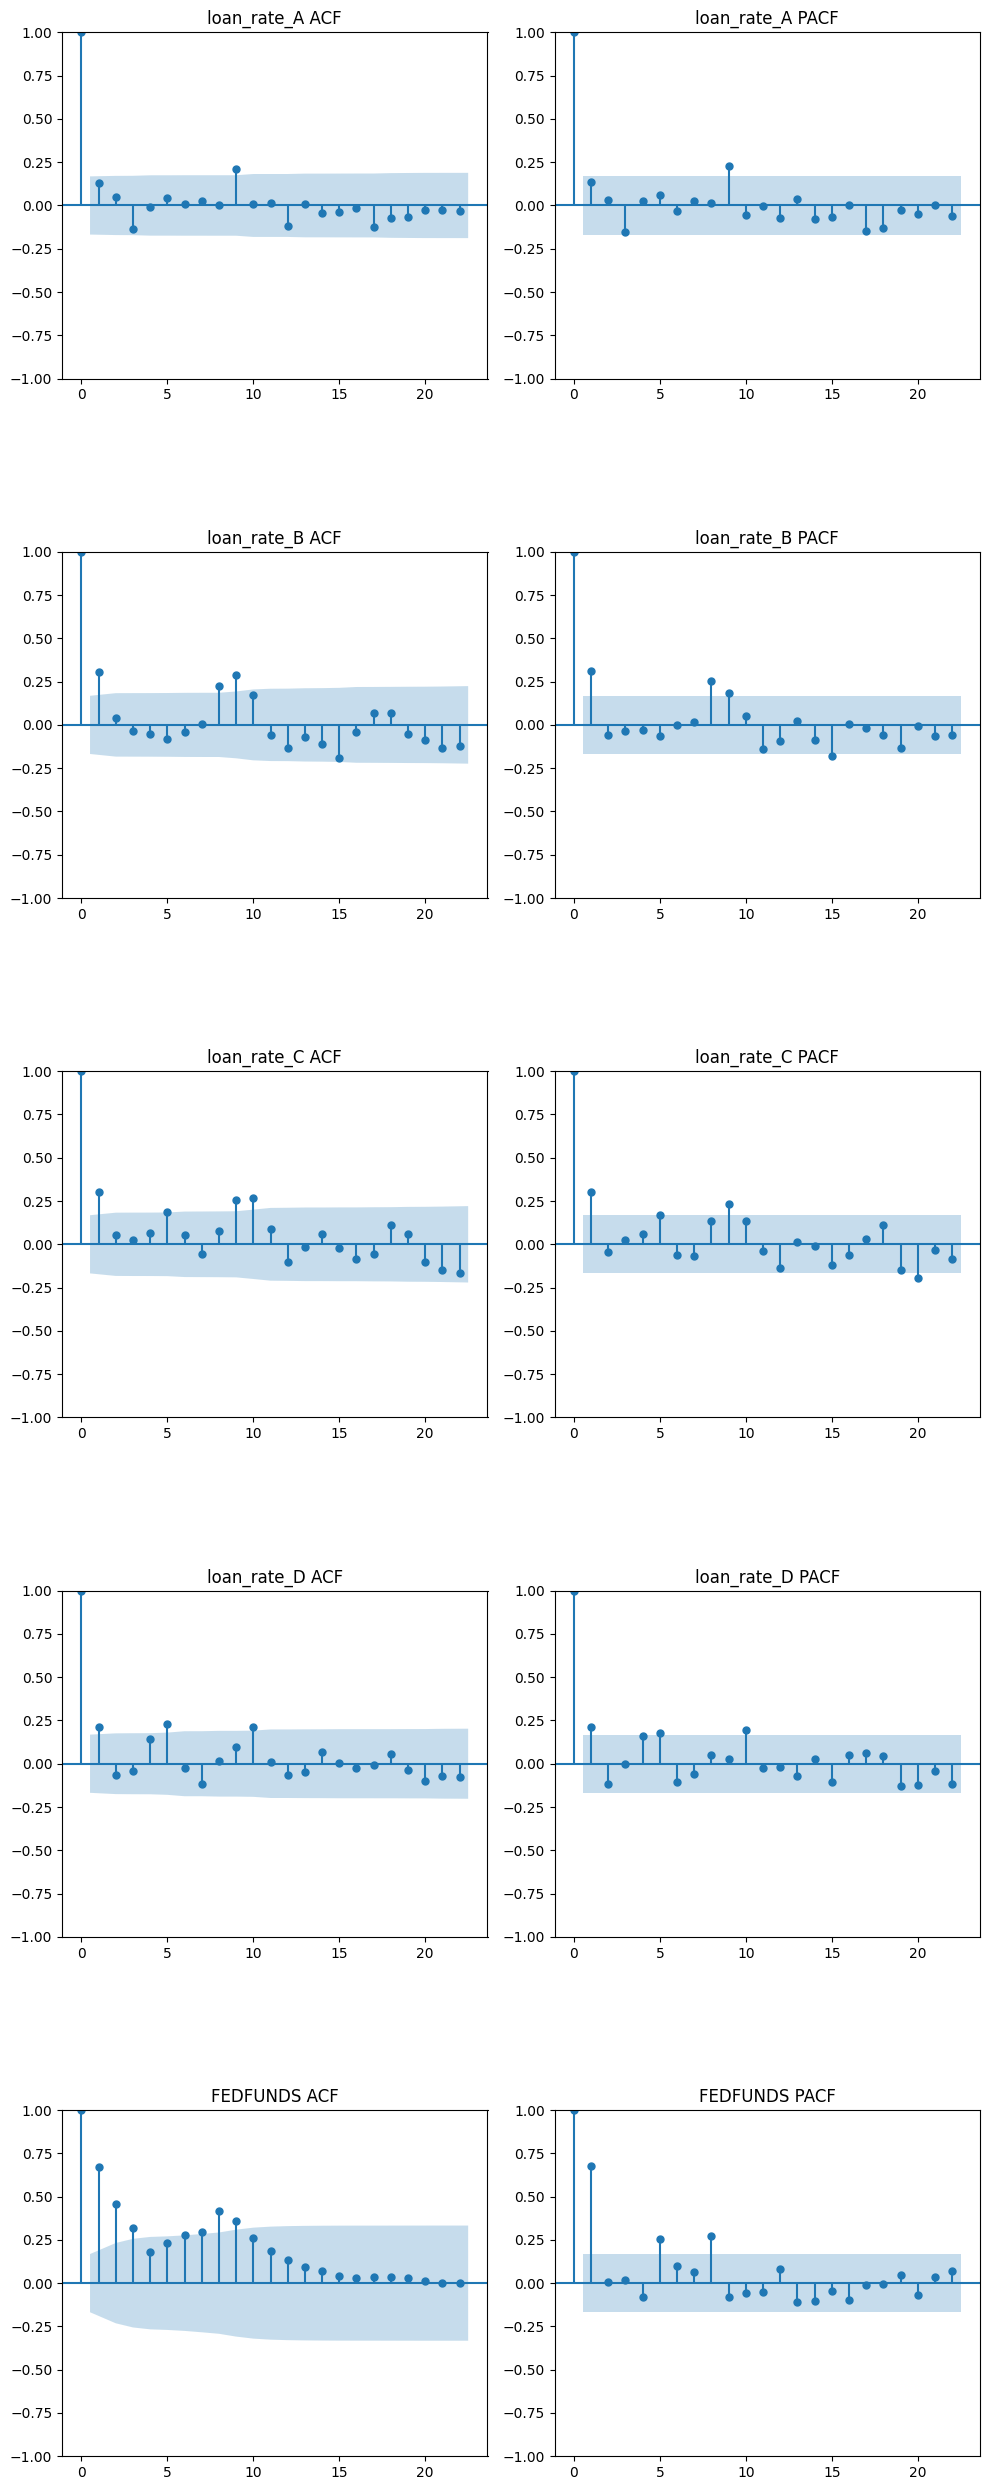

In [29]:
fig = plot_acf_pacf(df)
fig.show()

**Step 3: Residuals Analysis**

If there is seasonality in the ACF plot of the residuals, it suggests that there may be some autocorrelation remaining in the residuals at certain lags, which could be indicative of seasonality. This could be confirmed by looking at the PACF plot of the residuals as well.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



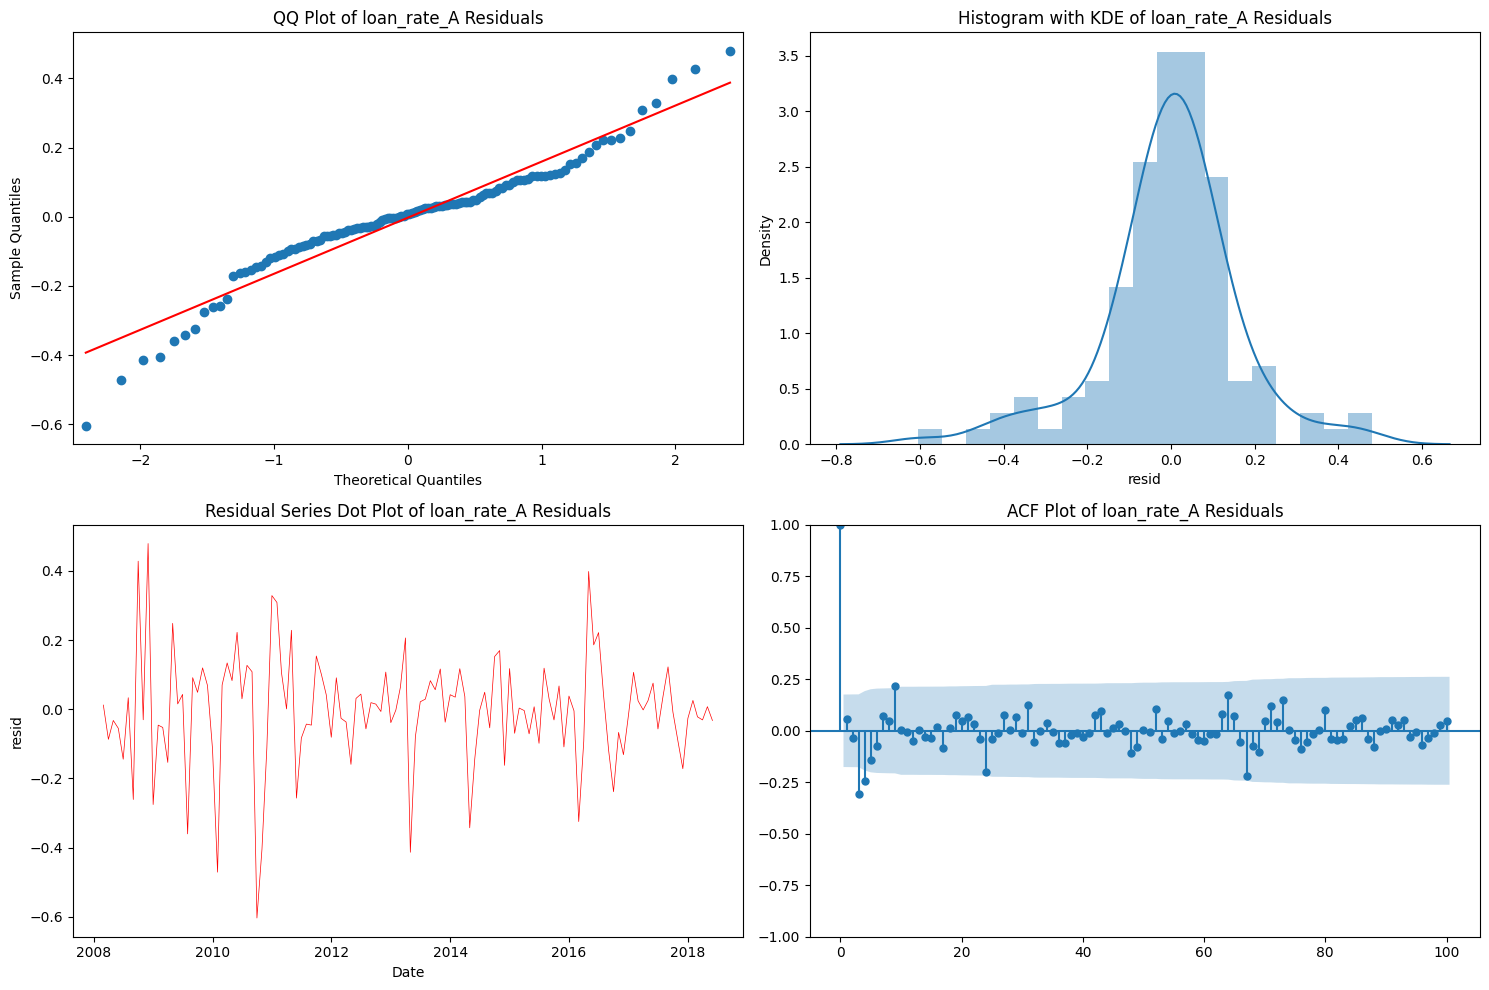

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



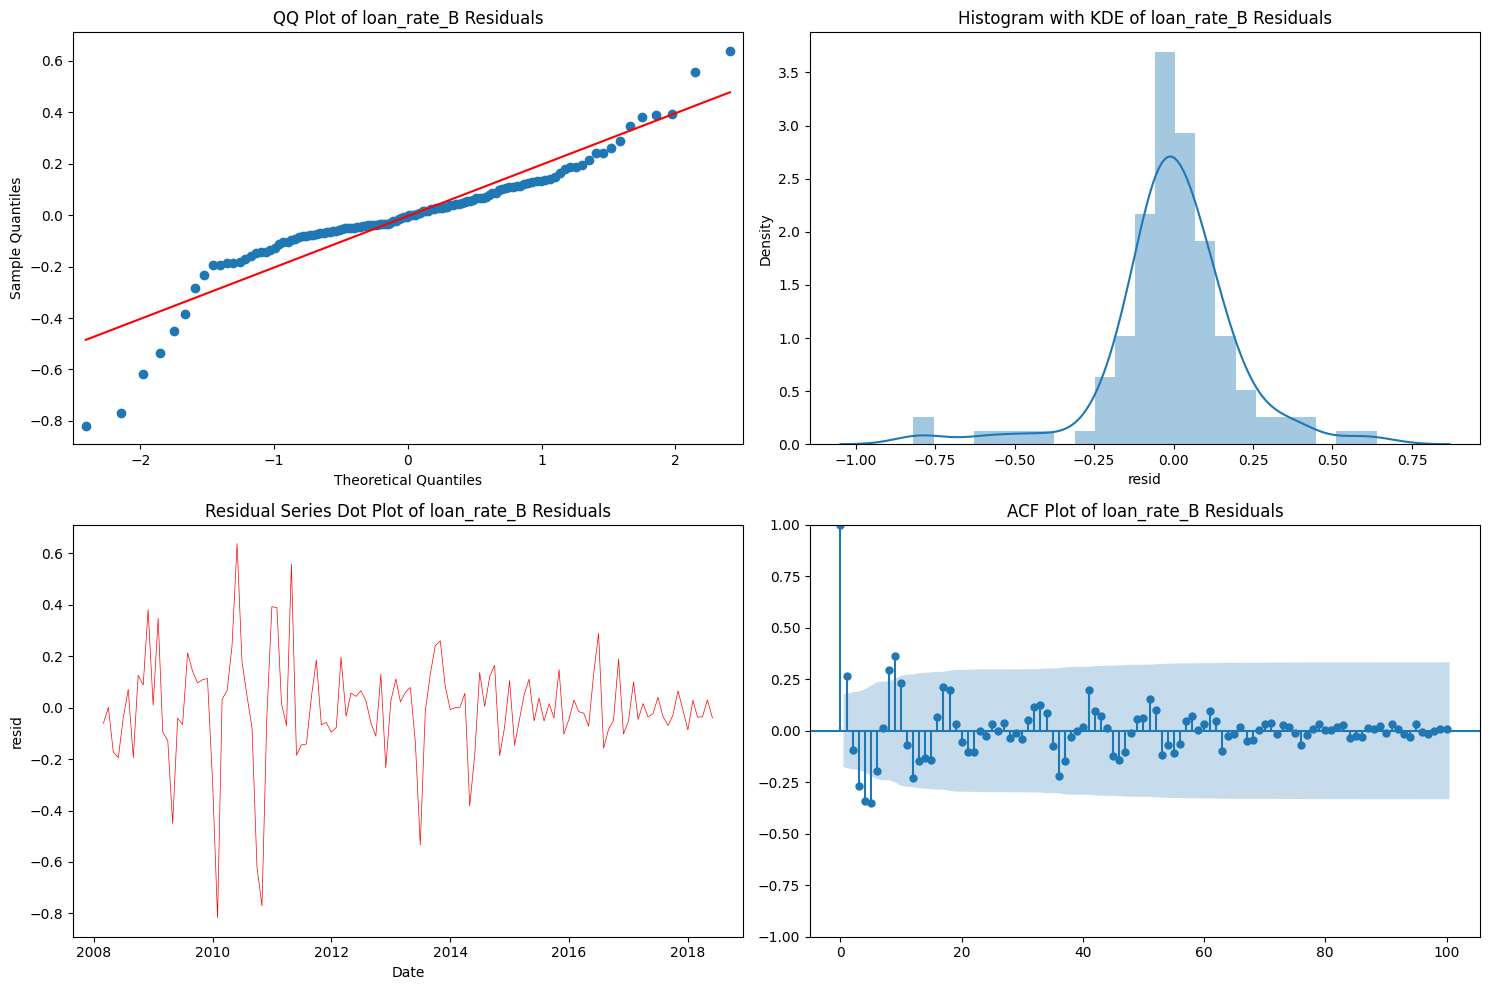

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



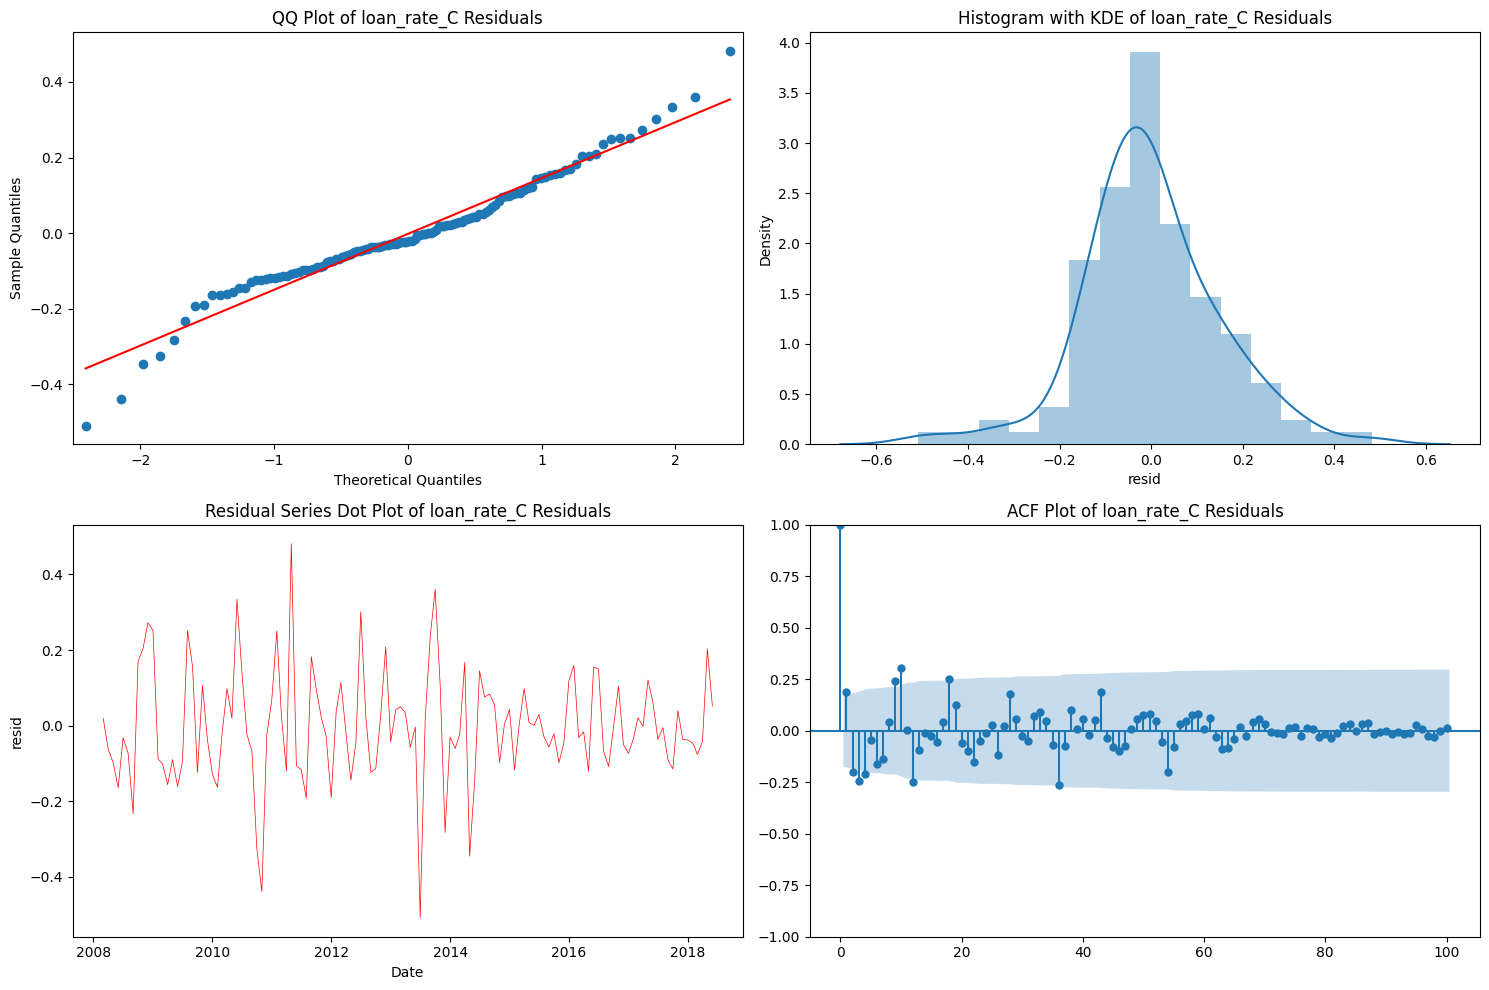

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



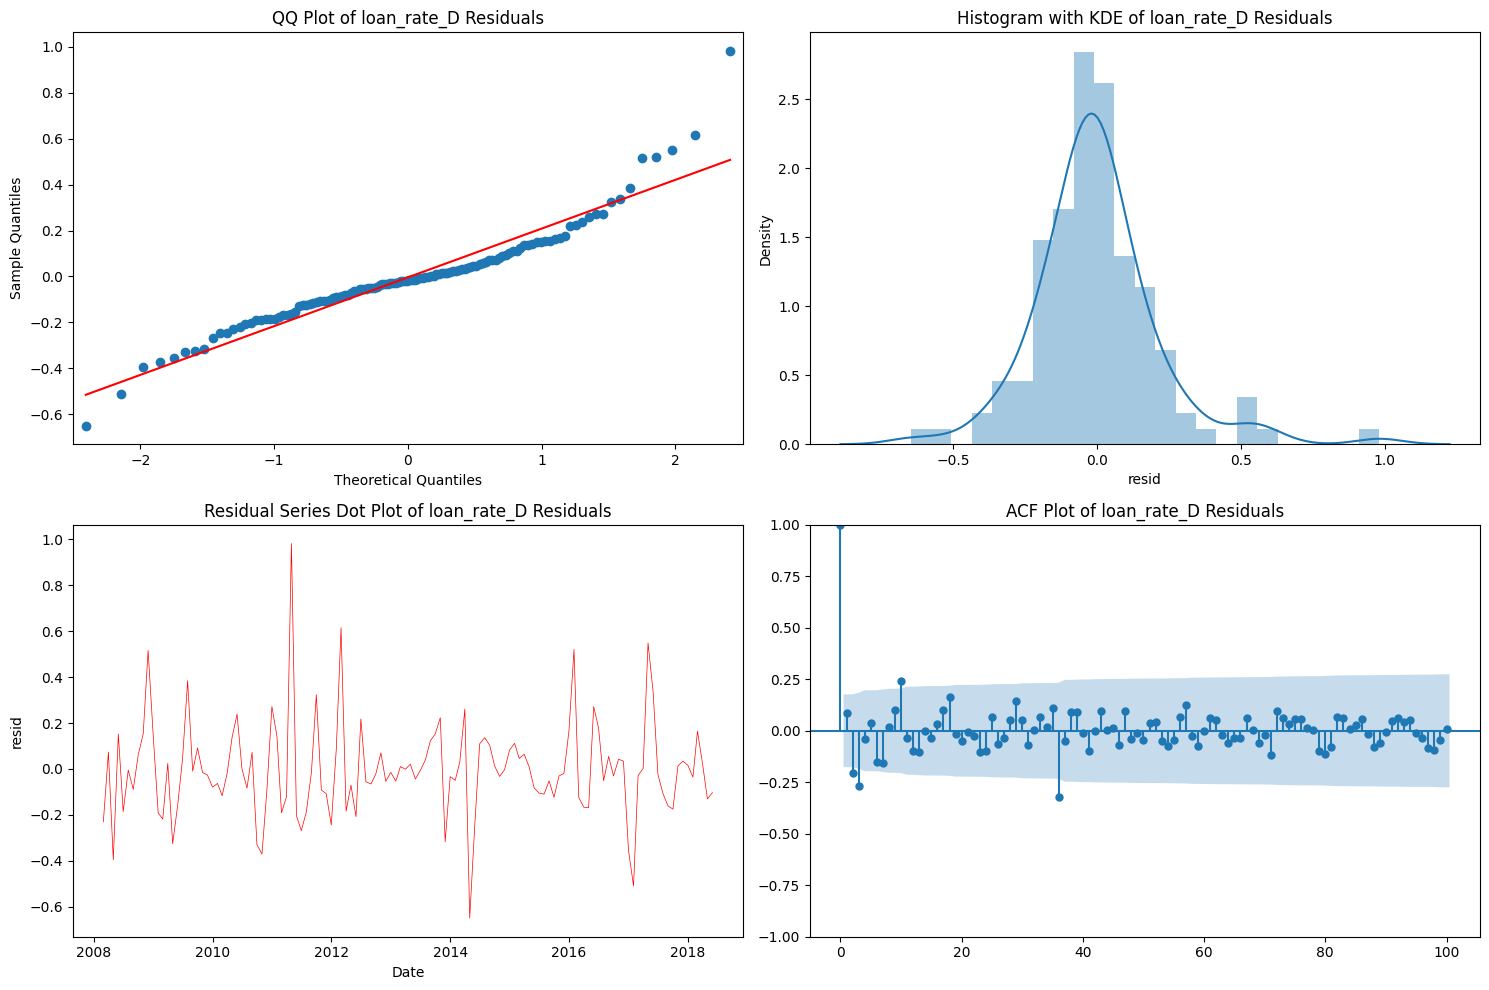

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



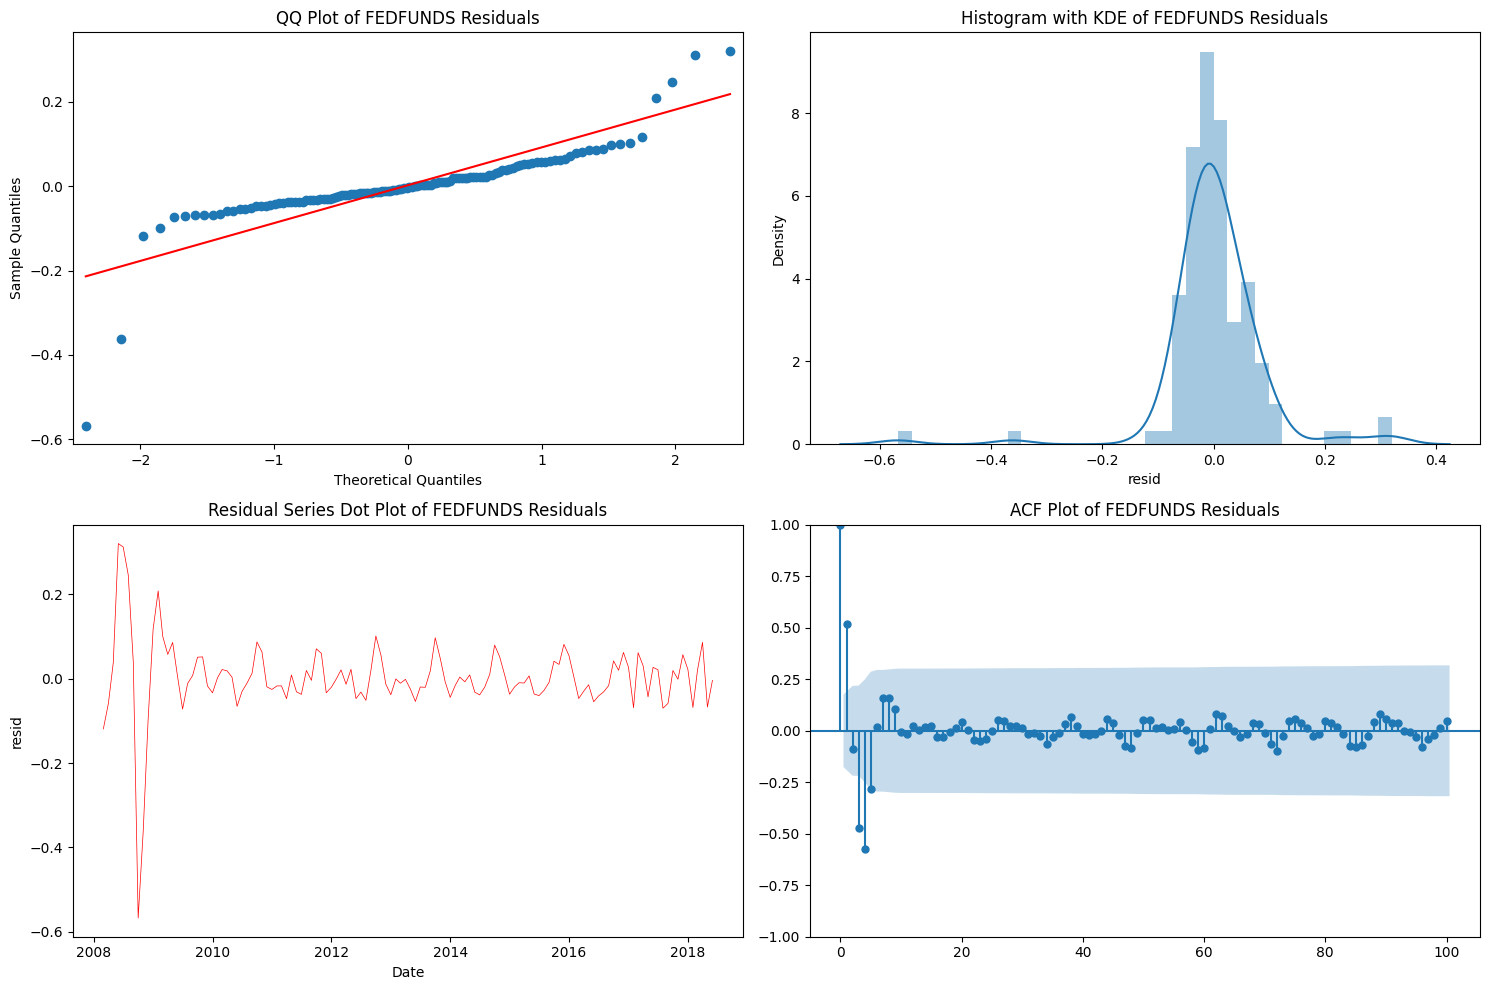

In [30]:
def residual_analysis(df):
    for col in df.columns:
        col_name = col + ' Residuals'
        decomp = seasonal_decompose(df[col], period=12)
        residuals = decomp.resid.dropna()

        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        ax = ax.flatten()

        # QQ plot
        qqplot(residuals, line='s', ax=ax[0])
        ax[0].set_title(f'QQ Plot of {col_name}')

        # Histogram with KDE
        sns.distplot(residuals, ax=ax[1])
        ax[1].set_title(f'Histogram with KDE of {col_name}')

        # Residual series dot plot
        sns.lineplot(data=residuals, linewidth=0.5, color='red', ax=ax[2])
        ax[2].set_title(f'Residual Series Dot Plot of {col_name}')

        # ACF plot
        plot_acf(residuals, ax=ax[3], lags=100)
        ax[3].set_title(f'ACF Plot of {col_name}')

        plt.tight_layout()
        plt.show()

residual_analysis(df)


Test if Residuals are Autocorrelated.

In [31]:
import pandas as pd
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox

def autocorrelation_tests(decomposition_dict, p_value_threshold=0.05):
    """
    Calculate p-values for Ljung-Box test, Runs test, and Box-Pierce test for each variable,
    and determine if they are autocorrelated or not based on the p-value threshold.

    Args:
        decomposition_dict (dict): A dictionary containing seasonal decomposition results for each variable.
        p_value_threshold (float): The p-value threshold for determining autocorrelation (default: 0.05).

    Returns:
        pd.DataFrame: A DataFrame containing the residuals, test names, p-values, threshold, pass/fail results, and autocorrelation decision.
    """
    results = []

    for column_name, decomposition in decomposition_dict.items():
        residuals = decomposition.resid.dropna()

        test_names = ['Ljung-Box', 'Runs Test', 'Box-Pierce Test']
        p_values = [
            acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
            runstest_1samp(residuals > 0)[1],
            acorr_ljungbox(residuals, lags=[10], boxpierce=True, return_df=True)['bp_pvalue'].iloc[0]
        ]

        for test_name, p_value in zip(test_names, p_values):
            pass_fail = 'Pass' if p_value > p_value_threshold else 'Fail'
            decision = 'not-autocorrelated' if pass_fail == 'Pass' else 'autocorrelated'

            results.append({
                'Residuals': column_name,
                'Test': test_name,
                'p-value': p_value,
                'Threshold': p_value_threshold,
                'Pass/Fail': pass_fail,
                'Decision': decision
            })

    test_results = pd.DataFrame(results)
    return test_results

# Example usage:
# Assuming 'decomposition_dict' is the dictionary containing the seasonal decomposition results
test_results = autocorrelation_tests(decomposition_dict)
display(test_results)





,Residuals,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,Ljung-Box,5.463022e-04,0.05,Fail,autocorrelated
1,loan_rate_A,Runs Test,6.058129e-01,0.05,Pass,not-autocorrelated
2,loan_rate_A,Box-Pierce Test,1.036218e-03,0.05,Fail,autocorrelated
3,loan_rate_B,Ljung-Box,1.400959e-15,0.05,Fail,autocorrelated
4,loan_rate_B,Runs Test,7.204444e-01,0.05,Pass,not-autocorrelated
5,loan_rate_B,Box-Pierce Test,1.950261e-14,0.05,Fail,autocorrelated
6,loan_rate_C,Ljung-Box,2.559360e-07,0.05,Fail,autocorrelated
7,loan_rate_C,Runs Test,5.459012e-03,0.05,Fail,autocorrelated
8,loan_rate_C,Box-Pierce Test,9.749741e-07,0.05,Fail,autocorrelated
9,loan_rate_D,Ljung-Box,4.670214e-04,0.05,Fail,autocorrelated


Interpretation of Autocorrelation Tests.

*Residuals are assumed to be **autocorrelated**.*

Test if Residuals are normally distributed.

In [32]:
import pandas as pd
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import kstest_normal, lilliefors
from statsmodels.stats.stattools import jarque_bera

def normality_tests(decomposition_dict, p_value_threshold=0.05):
    """
    Calculate p-values for Jarque-Bera, Kolmogorov-Smirnov, Shapiro-Wilk, and Lilliefors tests for each variable,
    and determine if their distribution is normal or not based on the p-value threshold.

    Args:
        decomposition_dict (dict): A dictionary containing seasonal decomposition results for each variable.
        p_value_threshold (float): The p-value threshold for determining normality (default: 0.05).

    Returns:
        pd.DataFrame: A DataFrame containing the residuals, test names, p-values, threshold, pass/fail results, and normality decision.
    """
    results = []

    for column_name, decomposition in decomposition_dict.items():
        residuals = decomposition.resid.dropna()

        test_names = ['Jarque-Bera', 'Kolmogorov-Smirnov', 'Shapiro-Wilk', 'Lilliefors']
        p_values = [
            jarque_bera(residuals)[1],
            kstest_normal(residuals)[1],
            shapiro(residuals)[1],
            lilliefors(residuals)[1]
        ]

        for test_name, p_value in zip(test_names, p_values):
            pass_fail = 'Pass' if p_value > p_value_threshold else 'Fail'
            decision = 'normal' if pass_fail == 'Pass' else 'not-normal'

            results.append({
                'Residuals': column_name,
                'Test': test_name,
                'p-value': p_value,
                'Threshold': p_value_threshold,
                'Pass/Fail': pass_fail,
                'Decision': decision
            })

    test_results = pd.DataFrame(results)
    return test_results

# Example usage:
# Assuming 'decomposition_dict' is the dictionary containing the seasonal decomposition results
test_results = normality_tests(decomposition_dict)
display(test_results)


,Residuals,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,Jarque-Bera,1.548336e-07,0.05,Fail,not-normal
1,loan_rate_A,Kolmogorov-Smirnov,1.578783e-03,0.05,Fail,not-normal
2,loan_rate_A,Shapiro-Wilk,4.571232e-05,0.05,Fail,not-normal
3,loan_rate_A,Lilliefors,1.578783e-03,0.05,Fail,not-normal
4,loan_rate_B,Jarque-Bera,8.235341e-26,0.05,Fail,not-normal
5,loan_rate_B,Kolmogorov-Smirnov,1.000000e-03,0.05,Fail,not-normal
6,loan_rate_B,Shapiro-Wilk,4.956242e-08,0.05,Fail,not-normal
7,loan_rate_B,Lilliefors,1.000000e-03,0.05,Fail,not-normal
8,loan_rate_C,Jarque-Bera,1.102293e-03,0.05,Fail,not-normal
9,loan_rate_C,Kolmogorov-Smirnov,4.374556e-02,0.05,Fail,not-normal


Interpretation of Normality Tests.

*Residuals are assumed to be **not normally distributed**.* 

**Step 3: Analyze the seasonality test results**

**Step 4: Interpret the results**



**Step 5: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

  ## A. Feature Analysis

## A.1. Univariate Analysis

### **Visual Inspection**

## A.2 Multivariave Analysis

### **Visual Inspection**

## B. Variable Selection

## B.1 Selection Process

### **ARIMA Analysis**

**Step 1: Identify Integration Order**

The first step in any time series analysis is to visualize the data and check for stationarity. Stationarity is important because most time series models, including ARIMA, assume that the underlying data is stationary.

Stationarity Analysis.

*In previous section it was determined that the **first difference makes the series stationary**, and therefore we assume **I = 1**. The `stationary_df` dataset contains the stationary series.* 

**Step 2: Identify the order of the AR model**

The order of the autoregressive (AR) model can be determined by looking at the partial autocorrelation function (PACF) plot. The PACF shows the correlation between a time series and its lagged values after accounting for the correlation at all shorter lags.

In [41]:
def find_ar_orders(df, max_lag):
    """
    Finds the appropriate AR order for each column in the input DataFrame using the PACF method.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        max_lag (int): The maximum number of lags to consider when calculating PACF.

    Returns:
        ar_orders_df (pd.DataFrame): A DataFrame containing the AR order, PACF value, and threshold
                                     for each column in the input DataFrame.
    """
    ar_orders = {}
    for col in df.columns:
        pacf_values, pacf_confidence_intervals = pacf(df[col], nlags=max_lag, alpha=0.05, method="ywmle")
        for lag, pacf_value, ci in zip(range(1, len(pacf_values)), pacf_values[1:], pacf_confidence_intervals[1:]):
            if ci[0] <= pacf_value <= ci[1]:
                ar_orders[col] = {"AR_order": lag - 1, "PACF_value": pacf_value, "threshold": ci[1]}
                break
    
    # Create a DataFrame from the ar_orders dictionary
    ar_orders_df = pd.DataFrame.from_dict(ar_orders, orient='index')
    ar_orders_df.reset_index(inplace=True)
    ar_orders_df.columns = ['Column', 'AR_order', 'PACF_value', 'threshold']
    
    return ar_orders_df



In [42]:
ar_orders = find_ar_orders(df, max_lag=20)
display(ar_orders)

,Column,AR_order,PACF_value,threshold
0,loan_rate_A,0,0.132210,0.300276
1,loan_rate_B,0,0.307366,0.475432
2,loan_rate_C,0,0.301507,0.469573
3,loan_rate_D,0,0.212277,0.380343
4,FEDFUNDS,0,0.672489,0.840554


Interpretation of PACF Test.

*If all columns have an AR order of 0, it means that the PACF method did not find any lag where the PACF value drops below the confidence interval threshold. This suggests that there is **no clear indication of autocorrelation in the data**.* 

*However, an AR(0) model is essentially a model with no autoregressive terms. In this case, the model would only consist of a constant term (intercept) and a white noise error term. It's equivalent to assuming that the time series is a constant value plus random noise.*

*It is generally unlikely for stationary loan rates to be well-represented by an AR(0) model. Loan rates are typically influenced by various economic factors, such as monetary policy, inflation expectations, and market conditions, which often exhibit some degree of autocorrelation structure. Therefore, an AR(p) model with a higher order (p > 0) would likely provide a better fit for loan rate time series..*

Fit Automatically Multiple AR models.

You can determine which AR order is better for each variable by comparing the BIC and AIC values. Lower values of BIC and AIC indicate a better fit for the model.

In [35]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_models(df, max_lag):
    """
    Fits multiple AR models to each column in the input DataFrame using the AutoReg class,
    and evaluates them using BIC and AIC criteria. Also checks for stationarity using the
    Augmented Dickey-Fuller (ADF) test. If a series is not stationary, a warning is issued.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        max_lag (int): The maximum number of lags to consider for the AR models.

    Returns:
        results_df (pd.DataFrame): A DataFrame containing the Variable, AR order, BIC, and AIC
                                   for each AR order for each column in the input DataFrame.
    """
    results_data = []

    for column_name in df.columns:
        adf_result = adfuller(df[column_name])
        is_stationary = adf_result[1] < 0.05

        if is_stationary:
            for lag in range(1, max_lag + 1):
                model = AutoReg(df[column_name], lags=lag, old_names=False)
                model_fit = model.fit()
                results_data.append({"Variable": column_name, "AR_order": lag, "BIC": model_fit.bic, "AIC": model_fit.aic})
        else:
            warnings.warn(f"{column_name} is not stationary. Results may be inaccurate.")
            results_data.append({"Variable": column_name, "AR_order": None, "BIC": None, "AIC": None})

    results_df = pd.DataFrame(results_data)
    return results_df




In [36]:
ar_results = fit_ar_models(df, max_lag=3)
display(ar_results)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind

,Variable,AR_order,BIC,AIC
0,loan_rate_A,1.0,-81.581140,-90.296965
1,loan_rate_A,2.0,-75.322357,-86.913716
2,loan_rate_A,3.0,-71.871312,-86.323057
3,loan_rate_B,1.0,-40.215964,-48.931789
4,loan_rate_B,2.0,-35.301299,-46.892658
5,loan_rate_B,3.0,-29.270327,-43.722072
6,loan_rate_C,1.0,-90.351299,-99.067123
7,loan_rate_C,2.0,-83.959665,-95.551024
8,loan_rate_C,3.0,-79.435479,-93.887224
9,loan_rate_D,1.0,0.033669,-8.682156


Interpretation of Auto AR Test.

*Based on the output, it seems that an **AR(1)** model is the best choice for all the stationary variables (`loan_rate_A`, `loan_rate_B`, `loan_rate_C`, and `loan_rate_D`).*

*`FEDFUNDS` is non-stationary (NaN values for BIC and AIC), and it is **not appropriate to determine an AR order** for it without first transforming the series to make it stationary.*

**Step 3: Identify the order of the MA model**

Identify the lag at which the autocorrelation drops to a value near zero, and this will give you the appropriate order of the MA model. For instance, if the ACF plot shows significant autocorrelations for the first 2 lags, and then the autocorrelation values are close to zero for the subsequent lags, the appropriate order of the MA model is likely MA(2).

In [39]:
def find_ma_orders(df, max_lag):
    """
    Finds the appropriate MA order for each column in the input DataFrame using the ACF method.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        max_lag (int): The maximum number of lags to consider when calculating ACF.

    Returns:
        ma_orders_df (pd.DataFrame): A DataFrame containing the MA order, ACF value, and threshold
                                     for each column in the input DataFrame.
    """
    ma_orders = {}
    for col in df.columns:
        acf_values, acf_confidence_intervals = acf(df[col], nlags=max_lag, alpha=0.05, fft=False)
        for lag, acf_value, ci in zip(range(1, len(acf_values)), acf_values[1:], acf_confidence_intervals[1:]):
            if ci[0] <= acf_value <= ci[1]:
                ma_orders[col] = {"MA_order": lag - 1, "ACF_value": acf_value, "threshold": ci[1]}
                break

    # Create a DataFrame from the ma_orders dictionary
    ma_orders_df = pd.DataFrame.from_dict(ma_orders, orient='index')
    ma_orders_df.reset_index(inplace=True)
    ma_orders_df.columns = ['Column', 'MA_order', 'ACF_value', 'threshold']

    return ma_orders_df

In [40]:
ma_orders = find_ma_orders(df, max_lag=20)
display(ma_orders)

,Column,MA_order,ACF_value,threshold
0,loan_rate_A,0,0.132210,0.300276
1,loan_rate_B,0,0.307366,0.475432
2,loan_rate_C,0,0.301507,0.469573
3,loan_rate_D,0,0.212277,0.380343
4,FEDFUNDS,0,0.672489,0.840554


Interpretation of ACF Test.

*For all the variables (`loan_rate_A`, `loan_rate_B`, `loan_rate_C`, `loan_rate_D`, and `FEDFUNDS`), the test suggests using an **MA(0)**. This means that there is no significant autocorrelation in the data for any of the variables, and using an MA model may not be necessary.*

Fit Automatically Multiple MA models.

You can determine which MA order is better for each variable by comparing the BIC and AIC values. Lower values of BIC and AIC indicate a better fit for the model.

In [43]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

def fit_ma_models(df, max_lag):
    """
    Fits multiple MA models to each column in the input DataFrame using the ARIMA class,
    and evaluates them using BIC and AIC criteria. Also checks for stationarity using the
    Augmented Dickey-Fuller (ADF) test. If a series is not stationary, a warning is issued.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        max_lag (int): The maximum number of lags to consider for the MA models.

    Returns:
        results_df (pd.DataFrame): A DataFrame containing the Variable, MA order, BIC, and AIC
                                   for each MA order for each column in the input DataFrame.
    """
    results_data = []

    for column_name in df.columns:
        adf_result = adfuller(df[column_name])
        is_stationary = adf_result[1] < 0.05

        if is_stationary:
            for lag in range(0, max_lag + 1):
                if lag == 0:
                    model = ARIMA(df[column_name], order=(0, 0, 0), trend='c')
                else:
                    model = ARIMA(df[column_name], order=(0, 0, lag), trend='c')
                model_fit = model.fit()
                results_data.append({"Variable": column_name, "MA_order": lag, "BIC": model_fit.bic, "AIC": model_fit.aic})
        else:
            warnings.warn(f"{column_name} is not stationary. Results may be inaccurate.")
            results_data.append({"Variable": column_name, "MA_order": None, "BIC": None, "AIC": None})

    results_df = pd.DataFrame(results_data)
    return results_df



In [44]:
ma_results = fit_ma_models(df, max_lag=3)
display(ma_results)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanvalidmind

,Variable,MA_order,BIC,AIC
0,loan_rate_A,0.0,-85.546446,-91.371756
1,loan_rate_A,1.0,-82.778760,-91.516725
2,loan_rate_A,2.0,-78.950058,-90.600678
3,loan_rate_A,3.0,-76.573498,-91.136773
4,loan_rate_B,0.0,-31.343924,-37.169234
5,loan_rate_B,1.0,-39.960136,-48.698101
6,loan_rate_B,2.0,-35.588359,-47.238979
7,loan_rate_B,3.0,-30.752218,-45.315493
8,loan_rate_C,0.0,-82.795641,-88.620951
9,loan_rate_C,1.0,-90.838904,-99.576869


Interpretation of Auto MA results.

*For all the variables, the results suggest that an **MA(0)** model would be the best choice based on both BIC and AIC values. The `FEDFUNDS` variable does not have any BIC or AIC values due to stationarity issues, as previously mentioned.*

*If a stationary loan rate series is found to be MA(0), it implies that the series is essentially a random process with a constant mean and no significant patterns or relationships between the data points that can be captured by a moving average model. This does not mean the series has no structure at all, but it does suggest that an MA model may not be the most appropriate choice for capturing the underlying dynamics of the data.*

*While the MA(0) model indicates that there is no significant autocorrelation in the data, it doesn't mean that the loan rates are entirely independent of other variables. The loan rates might be driven by external factors, such as macroeconomic variables, which are not captured in the MA(0) model.*